## Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as  plt
from IPython.display import clear_output
import torchvision.utils as vutils
import numpy as np



In [2]:
epochs = 400
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 1
resolution = 128
gen_type ="shuffle"



## Utils

In [3]:

def show_two_images(tensor1, tensor2, nrow=1, titles=("Image1", "Image2")):
    """
    Show two batches of images side by side.
    tensor1, tensor2: [B,C,H,W] PyTorch tensors
    """
    def denormalize(tensor):
        return (tensor * 0.5) + 0.5  # from [-1,1] to [0,1]

    # make grids from each tensor
    grid1 = vutils.make_grid(denormalize(tensor1).cpu(), nrow=nrow)
    grid2 = vutils.make_grid(denormalize(tensor2).cpu(), nrow=nrow)

    npimg1 = grid1.permute(1, 2, 0).detach().numpy()
    npimg2 = grid2.permute(1, 2, 0).detach().numpy()

    # plot side by side
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(npimg1)
    plt.axis("off")
    if titles and len(titles) > 0:
        plt.title(titles[0])

    plt.subplot(1, 2, 2)
    plt.imshow(npimg2)
    plt.axis("off")
    if titles and len(titles) > 1:
        plt.title(titles[1])

    plt.tight_layout()
    plt.show()

## Resnet Generator


In [4]:
# --- Basic building blocks ---
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

# --- Generator ---
class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=9):
        super().__init__()
        # Initial convolution
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, 64, 7),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = 64
        out_features = in_features * 2
        for _ in range(2):
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features * 2

        # Residual blocks
        for _ in range(n_residual_blocks):
            model += [ResidualBlock(in_features)]

        # Upsampling
        out_features = in_features // 2
        for _ in range(2):
            model += [
                nn.ConvTranspose2d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features
            out_features = in_features // 2

        # Output layer
        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, out_channels, 7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


## PixelShuffle Generator

In [5]:
import torch
import torch.nn as nn

# --- PixelShuffle Residual Block ---
class PSResBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels)
        )

    def forward(self, x):
        return x + self.block(x)

# --- PixelShuffle Upsample Block ---
class PixelShuffleUpsample(nn.Module):
    def __init__(self, in_channels, out_channels, upscale_factor=2):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels * (upscale_factor ** 2),
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.ps = nn.PixelShuffle(upscale_factor)
        self.norm = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.ps(x)
        x = self.norm(x)
        x = self.relu(x)
        return x

# --- Generator with PixelShuffle + PSResBlock ---
class PixelShuffleResGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=9, base_channels=64):
        super().__init__()

        # Initial convolution
        layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_channels, base_channels, kernel_size=7),
            nn.InstanceNorm2d(base_channels),
            nn.ReLU(inplace=True)
        ]

        # Downsampling
        in_features = base_channels
        for _ in range(2):
            out_features = in_features * 2
            layers += [
                nn.Conv2d(in_features, out_features, kernel_size=3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True)
            ]
            in_features = out_features

        # PSResBlocks
        for _ in range(n_residual_blocks):
            layers += [PSResBlock(in_features)]

        # Upsampling with PixelShuffle
        for _ in range(2):
            out_features = in_features // 2
            layers += [PixelShuffleUpsample(in_features, out_features, upscale_factor=2)]
            in_features = out_features

        # Output layer
        layers += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(base_channels, out_channels, kernel_size=7),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


## UNET Generator

In [6]:
import torch
import torch.nn as nn

class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_dropout=False):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.LeakyReLU(0.2, inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )
            if use_dropout:
                self.block.add_module("dropout", nn.Dropout(0.5))

    def forward(self, x):
        return self.block(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_filters=64):
        super().__init__()

        # Encoder
        self.down1 = UNetBlock(in_channels, base_filters, down=True)
        self.down2 = UNetBlock(base_filters, base_filters*2, down=True)
        self.down3 = UNetBlock(base_filters*2, base_filters*4, down=True)
        self.down4 = UNetBlock(base_filters*4, base_filters*8, down=True)
        self.down5 = UNetBlock(base_filters*8, base_filters*8, down=True)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_filters*8, base_filters*8, 4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.up1 = UNetBlock(base_filters*8, base_filters*8, down=False, use_dropout=True)
        self.up2 = UNetBlock(base_filters*16, base_filters*8, down=False, use_dropout=True)
        self.up3 = UNetBlock(base_filters*16, base_filters*4, down=False)
        self.up4 = UNetBlock(base_filters*8, base_filters*2, down=False)
        self.up5 = UNetBlock(base_filters*4, base_filters, down=False)

        self.final = nn.Sequential(
            nn.ConvTranspose2d(base_filters*2, out_channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        # downsample
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        bottleneck = self.bottleneck(d5)

        # upsample with skip connections
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d5], dim=1))
        u3 = self.up3(torch.cat([u2, d4], dim=1))
        u4 = self.up4(torch.cat([u3, d3], dim=1))
        u5 = self.up5(torch.cat([u4, d2], dim=1))
        return self.final(torch.cat([u5, d1], dim=1))


## Encoder Based

In [7]:
import torch
import torch.nn as nn

# --- Encoder ---
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=512):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 128, 4, stride=2, padding=1),  # 2x downsample
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),           # 4x downsample
            nn.ReLU(True),
            nn.Conv2d(256, hidden_dim, 3, stride=1, padding=1),
            nn.ReLU(True),
            # optional extra convs for capacity:
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.model(x)

# --- Codebook / Vector Quantizer ---
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings=1024, embedding_dim=512):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)

    def forward(self, z):
        B, C, H, W = z.shape
        z_flat = z.permute(0, 2, 3, 1).contiguous().view(-1, C)
        dist = (
            z_flat.pow(2).sum(1, keepdim=True)
            - 2 * z_flat @ self.embedding.weight.t()
            + self.embedding.weight.pow(2).sum(1)
        )
        indices = dist.argmin(1)
        quantized = self.embedding(indices).view(B, H, W, C).permute(0, 3, 1, 2).contiguous()
        return quantized, indices.view(B, H, W)

# --- Decoder ---
class Decoder(nn.Module):
    def __init__(self, out_channels=3, hidden_dim=512):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(hidden_dim, 256, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, out_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, z_q):
        return self.model(z_q)

# --- Latent Translator (CycleGAN generator in latent space) ---
class LatentTranslator(nn.Module):
    def __init__(self, dim=512, num_blocks=4):
        super().__init__()
        layers = []
        for _ in range(num_blocks):
            layers += [
                nn.Conv2d(dim, dim, 3, padding=1),
                nn.ReLU(True)
            ]
        self.model = nn.Sequential(*layers)

    def forward(self, z_q):
        return self.model(z_q)

# --- Putting it together for one direction X→Y ---
class VQCycleGenerator(nn.Module):
    def __init__(self,
                 encoderX=Encoder(),
                 quantizerX=VectorQuantizer(),
                 decoderY=Decoder(),
                 translatorXY=LatentTranslator()):
        super().__init__()
        self.encoderX = encoderX
        self.quantizerX = quantizerX
        self.translatorXY = translatorXY
        self.decoderY = decoderY

    def forward(self, x):
        z_x = self.encoderX(x)                       # encode image X
        z_qx, indices_x = self.quantizerX(z_x)       # quantize to codebook
        z_latent_y = self.translatorXY(z_qx)         # translate latent to Y
        out_y = self.decoderY(z_latent_y)            # decode into image Y
        return out_y


## PixelArt UNet

In [8]:


class PixelArtBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True):
        super().__init__()
        if down:
            self.block = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),  # no strided conv
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True),

            )
        else:
            # Nearest-neighbor upsampling + conv
            self.block = nn.Sequential(
                # nn.Upsample(scale_factor=2, mode='nearest'),
                nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

    def forward(self, x):
        return self.block(x)

class PixelArtUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, base_channels=64):
        super().__init__()

        # Encoder (no stride, just convs)
        self.enc1 = PixelArtBlock(in_channels, base_channels, down=True)
        self.enc2 = PixelArtBlock(base_channels, base_channels*2, down=True)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(base_channels*2, base_channels*2, 3, stride=1, padding=1),
            nn.ReLU(inplace=True)
        )

        # Decoder
        self.dec1 = PixelArtBlock(base_channels*2, base_channels, down=False)

        # Final conv
        self.final = nn.Sequential(
            nn.Conv2d(base_channels + base_channels, out_channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        b = self.bottleneck(e2)
        d1 = self.dec1(b)
        # skip connection
        out = self.final(torch.cat([d1, e1], dim=1))
        return out


## High Capacity Gen

In [9]:
class AdaIN(nn.Module):
    """Adaptive Instance Normalization"""
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale = nn.Linear(w_dim, channels)
        self.style_bias = nn.Linear(w_dim, channels)

    def forward(self, x, w):
        normalized = self.instance_norm(x)
        style_scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        style_bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return style_scale * normalized + style_bias

class NoiseInjection(nn.Module):
    """Adds channel-wise noise with learnable scaling"""
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        noise = torch.randn(x.size(0), 1, x.size(2), x.size(3), device=x.device)
        return x + self.weight * noise

class GeneratorBlock(nn.Module):
    """
    Generator block with convolution, AdaIN, and noise injection
    (no upsampling so resolution stays the same)
    """
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.adain = AdaIN(out_channels, w_dim)
        self.noise = NoiseInjection(out_channels)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x, w):
        x = self.conv(x)
        x = self.adain(x, w)
        x = self.noise(x)
        return self.activation(x)

class HighCapGenerator(nn.Module):
    """
    High-capacity generator that takes an RGB image and outputs
    an RGB image of the same resolution, using a learnable style vector.
    """
    def __init__(self, input_channels=3, w_dim=512,
                 base_channels=512, resolution=256, num_blocks=4):
        super().__init__()

        # Learnable style vector w
        self.w = nn.Parameter(torch.randn(1, w_dim))

        self.blocks = nn.ModuleList()
        self.to_rgb = nn.Conv2d(base_channels, 3, kernel_size=1)

        in_ch = input_channels
        out_ch = base_channels
        for _ in range(num_blocks):
            self.blocks.append(GeneratorBlock(in_ch, out_ch, w_dim))
            in_ch = out_ch  # subsequent blocks use base_channels in/out

        self.final_activation = nn.Tanh()

    def forward(self, x_img):
        """
        x_img: [B, 3, H, W] input image
        """
        # broadcast w to batch size
        w = self.w.expand(x_img.size(0), -1)  # [B, w_dim]

        x = x_img
        for block in self.blocks:
            x = block(x, w)
        x = self.to_rgb(x)
        return self.final_activation(x)


## Discriminator

In [10]:
# --- Discriminator ---
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        def discriminator_block(in_filters, out_filters, normalization=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalization:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(in_channels, 64, normalization=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            nn.Conv2d(256, 512, 4, stride=1, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

In [11]:
class ResidualDiscriminatorBlock(nn.Module):
    """Residual block for discriminator with downsampling"""
    def __init__(self, in_channels, out_channels, device=None):
        super().__init__()
        # define the layers first
        self.residual = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
            nn.LeakyReLU(0.2)
        )
        self.main = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )

        # move the block to the specified device
        if device is not None:
            self.to(device)
        self.device = device

    def forward(self, x):

        residual = self.residual(x)
        x = self.main(x)
        return x + residual

class ResidualDiscriminator(nn.Module):
    """Discriminator with residual blocks and spectral normalization"""
    def __init__(self, base_channels=64, max_resolution=resolution):
        super().__init__()
        self.initial_conv = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(3, base_channels, kernel_size=3, padding=1)),
            nn.LeakyReLU(0.2)
        )
        self.blocks = nn.ModuleList()
        resolutions = [max_resolution // (2 ** i) for i in range(int(np.log2(max_resolution)) - 1)]
        channels = [base_channels * (2 ** i) for i in range(len(resolutions))]
        
        for in_ch, out_ch in zip(channels, channels[1:]):
            self.blocks.append(ResidualDiscriminatorBlock(in_ch, out_ch,device=device))
        
        self.final_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.utils.spectral_norm(nn.Linear(channels[-1], 1))

    def forward(self, x):
        x = self.initial_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.final_pool(x).squeeze()
        return self.fc(x)

## Dataset Loader

In [12]:
class ImageDataset(Dataset):
    def __init__(self, root_X, root_Y, transform=None):
        self.files_X = [os.path.join(root_X, f) for f in os.listdir(root_X) if f.endswith(('jpg','png','jpeg'))]
        self.files_Y = [os.path.join(root_Y, f) for f in os.listdir(root_Y) if f.endswith(('jpg','png','jpeg'))]
        self.transform = transform

    def __len__(self):
        # number of iterations = max of both sets
        return max(len(self.files_X), len(self.files_Y))

    def __getitem__(self, index):
        # domain X image
        img_X_path = self.files_X[index % len(self.files_X)]
        img_X = Image.open(img_X_path).convert('RGB')

        # random domain Y image (unaligned)
        img_Y_path = random.choice(self.files_Y)
        img_Y = Image.open(img_Y_path).convert('RGB')

        if self.transform:
            img_X = self.transform(img_X)
            img_Y = self.transform(img_Y)

        return img_X, img_Y


In [13]:
transform = transforms.Compose([
    transforms.Resize((resolution,resolution)),         # resize all images
    transforms.ToTensor(),                # [0,1]
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))  # [-1,1]
])

In [14]:
dataset_folder='landscape_dataset'

dataset = ImageDataset(root_X=f'{dataset_folder}/trainA', root_Y=f'{dataset_folder}/trainB', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


## Loss Functions

In [15]:
# Losses
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_identity = nn.L1Loss()


## Training

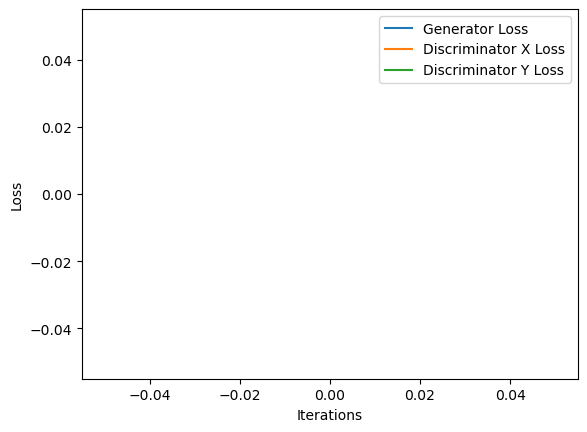

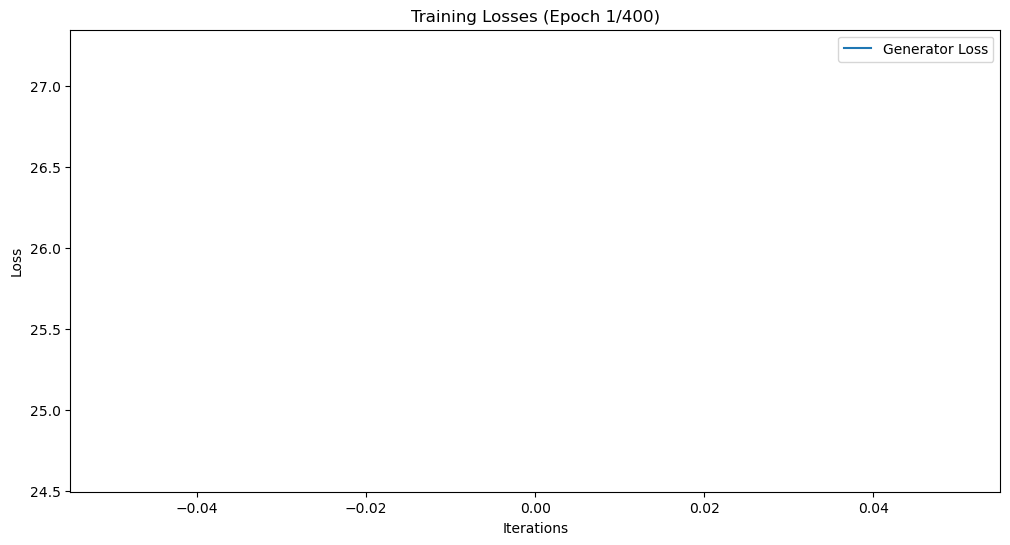

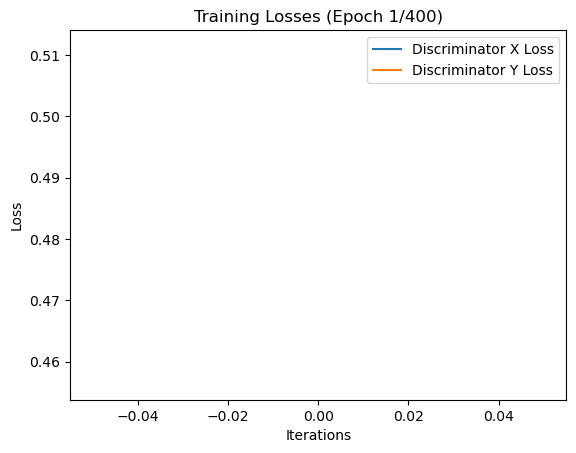

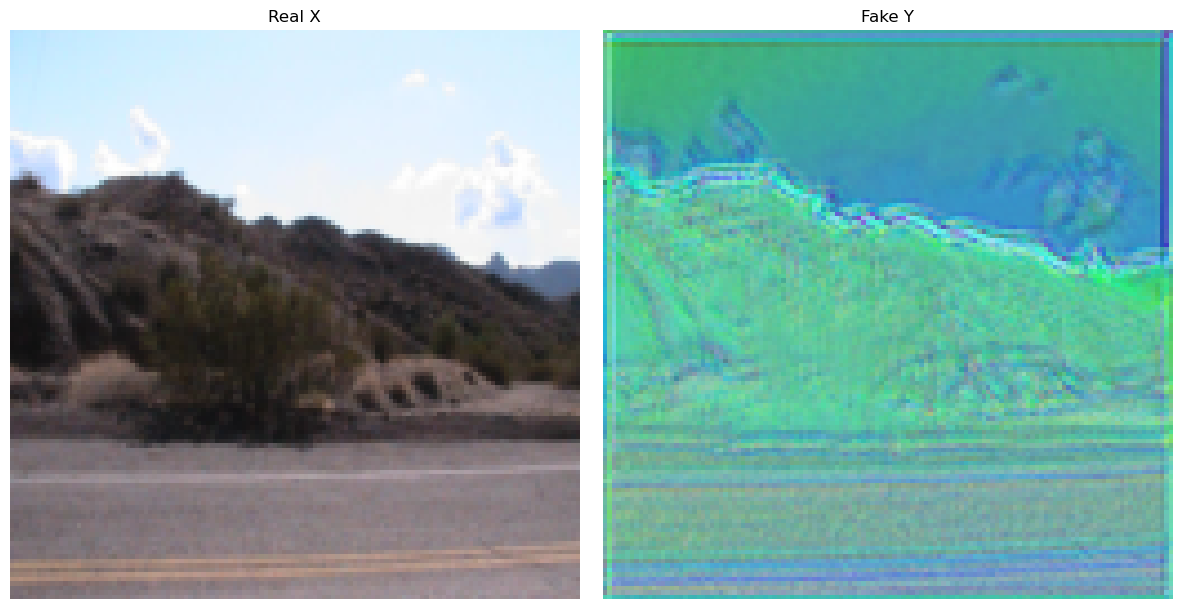

KeyboardInterrupt: 

In [16]:
# Initialize models
G_XtoY = HighCapGenerator().to(device=device)
G_YtoX = HighCapGenerator().to(device=device)
Disc_X = ResidualDiscriminator().to(device=device)
Disc_Y = ResidualDiscriminator().to(device=device)

# Optimizers
optimizer_G = optim.Adam(
    list(G_XtoY.parameters()) + list(G_YtoX.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_X = optim.Adam(Disc_X.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_Y = optim.Adam(Disc_Y.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Store losses for visualization
losses_G, losses_D_X, losses_D_Y = [], [], []
losses_cycle, losses_identity = [], []



plt.ion()
fig, ax = plt.subplots()
line1, = ax.plot([], [], label="Generator Loss")
line2, = ax.plot([], [], label="Discriminator X Loss")
line3, = ax.plot([], [], label="Discriminator Y Loss")
ax.legend()
ax.set_xlabel("Iterations")
ax.set_ylabel("Loss")
iteration=0

# Training loop skeleton
for epoch in range(epochs):
    for real_X, real_Y in dataloader:  # load mini-batches
        real_X, real_Y = real_X.to(device), real_Y.to(device)

        # ----------------------
        #  Train Generators
        # ----------------------
        optimizer_G.zero_grad()

        fake_Y = G_XtoY(real_X)
        loss_GAN_XtoY = criterion_GAN(Disc_Y(fake_Y), torch.ones_like(Disc_Y(fake_Y)))

        fake_X = G_YtoX(real_Y)
        loss_GAN_YtoX = criterion_GAN(Disc_X(fake_X), torch.ones_like(Disc_X(fake_X)))
        

        # Cycle loss
        recov_X = G_YtoX(fake_Y)
        recov_Y = G_XtoY(fake_X)
        loss_cycle = criterion_cycle(recov_X, real_X) + criterion_cycle(recov_Y, real_Y)

        # Identity loss
        loss_id_X = criterion_identity(G_YtoX(real_X), real_X)
        loss_id_Y = criterion_identity(G_XtoY(real_Y), real_Y)

        # Total generator loss
        loss_G = loss_GAN_XtoY + loss_GAN_YtoX + 10.0 * loss_cycle + 5.0 * (loss_id_X + loss_id_Y)
        loss_G.backward()
        optimizer_G.step()

        # -----------------------
        #  Train Discriminator X
        # -----------------------
        optimizer_D_X.zero_grad()

        loss_real = criterion_GAN(Disc_X(real_X), torch.ones_like(Disc_X(real_X)))
        loss_fake = criterion_GAN(Disc_X(fake_X.detach()), torch.zeros_like(Disc_X(fake_X)))
        loss_D_X = (loss_real + loss_fake) * 0.5
        loss_D_X.backward()
        optimizer_D_X.step()

        # -----------------------
        #  Train Discriminator Y
        # -----------------------
        optimizer_D_Y.zero_grad()

        loss_real = criterion_GAN(Disc_Y(real_Y), torch.ones_like(Disc_Y(real_Y)))
        loss_fake = criterion_GAN(Disc_Y(fake_Y.detach()), torch.zeros_like(Disc_Y(fake_Y)))
        loss_D_Y = (loss_real + loss_fake) * 0.5
        loss_D_Y.backward()
        optimizer_D_Y.step()
        
        ## Store losses
        losses_G.append(loss_G.item())
        losses_D_X.append(loss_D_X.item())
        losses_D_Y.append(loss_D_Y.item())
        losses_cycle.append(loss_cycle.item())
        losses_identity.append((loss_id_X + loss_id_Y).item())
        
        if iteration % 20 == 0:
            clear_output(wait=True)
            plt.figure(figsize=(12,6))
            
            plt.plot(losses_G, label="Generator Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.title(f"Training Losses (Epoch {epoch+1}/{epochs})")
            plt.show()
            
            plt.plot(losses_D_X, label="Discriminator X Loss")
            plt.plot(losses_D_Y, label="Discriminator Y Loss")
            plt.xlabel("Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.title(f"Training Losses (Epoch {epoch+1}/{epochs})")
            plt.show()
            
            show_two_images(real_X, fake_Y, nrow=2, titles=("Real X", "Fake Y"))
        iteration += 1

        
    # -----------------------
    # Save models every few epochs
    # -----------------------
    if (epoch + 1) % 10 == 0:
        save_dir = f"models/{dataset_folder}_{gen_type}/epoch_{epoch}"

        # create directories if they don’t exist
        os.makedirs(save_dir, exist_ok=True)

        # now save your weights
        torch.save(G_XtoY.state_dict(), os.path.join(save_dir, "G_XtoY.pth"))
        torch.save(G_YtoX.state_dict(), os.path.join(save_dir, "G_YtoX.pth"))
        torch.save(Disc_X.state_dict(), os.path.join(save_dir, "Disc_X.pth"))
        torch.save(Disc_Y.state_dict(), os.path.join(save_dir, "Disc_Y.pth"))
        print(f"Saved models at epoch {epoch+1}")
